## tool.py  用于回测 以及 因子有效性的测试

#### 因子有效性检验框架
考虑到可能存在的情形是，当天发出买卖信号持有至收盘，
计算IC为分钟信号与分钟收盘价到当日收盘价收益的相关系数
只考虑量价因子

## 一、连接wind数据库

In [1]:
from utils import *
from main import *
from WindPy import w
w.start()
w.isconnected()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


True

## 二、获取数据并保存至本地
起始日期 2022年2月14日-2025年2月11日

In [132]:
codes = ['588080.SH','159915.SZ']
fields = 'open,high,low,close,volume,amt,chg,pct_chg,'
begin_time = '2022-02-11 09:30:00'
end_time = '2025-02-11 15:00:00'
error, data = w.wsi(codes, fields, begin_time, end_time, "Fill=Previous",usedf=True)  #不复权 
### 剔除11:30和15:00的数据
data = data[(data.index.strftime("%H:%M")!="11:30") & (data.index.strftime("%H:%M")!="15:00")]
data.to_parquet('ETF_minquotes.parquet') 

## 三、因子构造

In [3]:
## 分别读取科创50ETF和创业板ETF的分钟频数据
ETF_minquotes = pd.read_parquet('ETF_minquotes.parquet')
F588080 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '588080.SH']
F159915 = ETF_minquotes.loc[ETF_minquotes['windcode'] == '159915.SZ']
F588080.loc[:,'htc_ret'] = F588080.groupby(F588080.index.date).apply(lambda x:x['close'].iloc[-1]/x['open'].shift(-1)-1).values
F159915.loc[:,'htc_ret'] = F159915.groupby(F159915.index.date).apply(lambda x:x['close'].iloc[-1]/x['open'].shift(-1)-1).values


In [19]:
seq_len = 30
seq_gap = 5
factor_list = ['open','high','low','close','volume']
label_name = 'htc_ret'
def make_dataset(F588080_temp, F159915_temp, seq_len, seq_gap, factor_list, label_name):
    data = []
    label = []
    for Fund_code, Fund_temp in zip(['F588080.SH', 'F159915.SZ'],[F588080_temp, F159915_temp]):
        Fund_temp = Fund_temp[Fund_temp.index.strftime('%H:%M')<='14:00']
        for i in tqdm(range(seq_len, len(Fund_temp), seq_gap)):
            ## 考虑每个特征时序相对位置的变化，即归一化操作
            temp_data = Fund_temp.iloc[i-seq_len:i][factor_list].rank(axis=0,pct=True).values
            temp_label = Fund_temp.iloc[i-1][label_name]
            # index = Fund_temp.iloc[i-1].index
            
            if np.isnan(temp_data).sum()+np.isnan(temp_label) == 0:
                data.append(temp_data)
                label.append((Fund_temp.iloc[i-1].name,Fund_code,temp_label))
    return np.array(data), pd.DataFrame(label,columns=['time','Fund_code','htc_ret'])

data, label = make_dataset(F588080, F159915, seq_len, seq_gap, factor_list, label_name)

100%|██████████| 26239/26239 [00:24<00:00, 1063.22it/s]


In [ ]:
with open(f'{localpath}/data/{data_name}.pickle', 'rb') as file:
    loaded_data = pickle.load(file)

,time,Fund_code,htc_ret
0,2022-02-14 09:59:00,F588080.SH,-0.004125
1,2022-02-14 10:04:00,F588080.SH,-0.002479
2,2022-02-14 10:09:00,F588080.SH,0.000829
3,2022-02-14 10:14:00,F588080.SH,0.000000
4,2022-02-14 10:19:00,F588080.SH,0.000000
...,...,...,...
52473,2025-02-11 13:35:00,F159915.SZ,-0.003770
52474,2025-02-11 13:40:00,F159915.SZ,-0.003770
52475,2025-02-11 13:45:00,F159915.SZ,-0.000945
52476,2025-02-11 13:50:00,F159915.SZ,-0.000473


In [18]:
test1 = [(1,2,3),(2,3,4)]
pd.DataFrame(test1,columns=['a','b','c'])

,a,b,c
0,1,2,3
1,2,3,4


In [15]:
label.index

MultiIndex([('2022-02-14 09:59:00', 'F588080.SH'),
            ('2022-02-14 10:04:00', 'F588080.SH'),
            ('2022-02-14 10:09:00', 'F588080.SH'),
            ('2022-02-14 10:14:00', 'F588080.SH'),
            ('2022-02-14 10:19:00', 'F588080.SH'),
            ('2022-02-14 10:24:00', 'F588080.SH'),
            ('2022-02-14 10:29:00', 'F588080.SH'),
            ('2022-02-14 10:34:00', 'F588080.SH'),
            ('2022-02-14 10:39:00', 'F588080.SH'),
            ('2022-02-14 10:44:00', 'F588080.SH'),
            ...
            ('2025-02-11 13:10:00', 'F159915.SZ'),
            ('2025-02-11 13:15:00', 'F159915.SZ'),
            ('2025-02-11 13:20:00', 'F159915.SZ'),
            ('2025-02-11 13:25:00', 'F159915.SZ'),
            ('2025-02-11 13:30:00', 'F159915.SZ'),
            ('2025-02-11 13:35:00', 'F159915.SZ'),
            ('2025-02-11 13:40:00', 'F159915.SZ'),
            ('2025-02-11 13:45:00', 'F159915.SZ'),
            ('2025-02-11 13:50:00', 'F159915.SZ'),
            ('2

In [9]:
F588080.iloc[0].name

Timestamp('2022-02-14 09:30:00')

In [ ]:
label

In [ ]:
minquote = F588080
factor_name = 'skew_10min'
minquote[factor_name] = minquote['pctchange'].groupby(minquote.index.date).transform(lambda x:x.rolling(30).skew())
IC1mean , IC2mean = FactorIC(minquote,factor_name)

### 3.1 手动挖掘的信号因子

In [24]:
from utils import *

In [21]:
minquote = F588080
minquote = F159915

#### 3.1.1 成交量分布的高阶矩

In [25]:
minquote.loc[:,'volume_ratio'] = minquote['volume']/minquote['volume'].rolling(240,min_periods=60).mean()

### 3.2 查看GRU因子的表现，机器学习自动产出的因子

In [16]:
localpath = '.'
with open(f'{localpath}/test1.yaml', 'r') as file:
    args = DictToObj(yaml.safe_load(file))
set_seed(args.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel(input_size=len(args.FACTOR_LIST), hidden_size=args.HIDDEN_SIZE, num_layers=args.NUM_LAYERS, output_size=1)
model.to(device)

model.load_state_dict(torch.load(f'{localpath}/model.pth'))
model.eval()

with open(f'{localpath}/data/Test_data.pickle', 'rb') as file:
    Test_data = pickle.load(file)
with open(f'{localpath}/data/Test_label.pickle', 'rb') as file:
    Test_label = pickle.load(file)

TestDataloader = DataLoader(MyDataset(Test_data, Test_label), batch_size=args.BATCH_SIZE)
result = []
for inputs, labels in TestDataloader:
    inputs = inputs.float().to(device)
    labels = labels.float().to(device)
    with torch.no_grad():  # 关闭梯度计算
        loss, output = model(inputs,labels.unsqueeze(1))
    result.append(output.cpu().detach().numpy())

In [19]:
Fund_temp = F588080
i=30
seq_len = 30
factor_list = ['open','high','low','close','volume']
Fund_temp.iloc[i-seq_len:i][factor_list].rank(axis=0,pct=True).values

array([[0.38333333, 0.3       , 0.1       , 0.06666667, 0.96666667],
       [0.06666667, 0.03333333, 0.05      , 0.03333333, 0.93333333],
       [0.03333333, 0.06666667, 0.05      , 0.1       , 0.73333333],
       [0.1       , 0.13333333, 0.13333333, 0.23333333, 0.66666667],
       [0.28333333, 0.41666667, 0.36666667, 0.5       , 0.86666667],
       [0.53333333, 0.51666667, 0.55      , 0.5       , 0.9       ],
       [0.53333333, 0.51666667, 0.55      , 0.6       , 0.56666667],
       [0.65      , 0.7       , 0.73333333, 0.6       , 0.7       ],
       [0.65      , 0.7       , 0.73333333, 0.7       , 0.83333333],
       [0.73333333, 0.7       , 0.73333333, 0.76666667, 0.5       ],
       [0.78333333, 0.78333333, 0.55      , 0.41666667, 0.76666667],
       [0.46666667, 0.41666667, 0.41666667, 0.41666667, 0.63333333],
       [0.38333333, 0.3       , 0.3       , 0.31666667, 0.8       ],
       [0.38333333, 0.36666667, 0.3       , 0.23333333, 1.        ],
       [0.21666667, 0.21666667, 0.

In [1]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.3.0+cu118
11.8
8700


In [17]:
result

[array([[-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0.00104889],
        [-0

## 四、日内动量策略
目前还差一个止损条件

In [150]:
def GetMomBound(minquote):
    """计算动量策略的上下限"""
    minquote.loc[:,'open0930'] = minquote.groupby(minquote.index.date)['open'].transform(lambda x: x.iloc[0])  # 0930开盘价
    minquote.loc[:,'move'] = (minquote['close']/minquote['open0930']-1).abs()  # 计算每分钟的价格位移
    minquote.loc[:,'move_rolling10'] = minquote.groupby(minquote.index.strftime('%H:%M'))['move'].transform(lambda x: x.rolling(10,min_periods=5).mean())
    minquote.loc[:,'close_last'] = (minquote.groupby(minquote.index.date)['close'].transform(lambda x: x.iloc[-1])).shift(240)  # 前一日收盘价
    minquote.loc[:,'upper_bound'] = minquote[['open0930','close_last']].max(axis=1)*(1+minquote['move_rolling10'])  # 计算上限
    minquote.loc[:,'lower_bound'] = minquote[['open0930','close_last']].min(axis=1)*(1-minquote['move_rolling10'])  # 计算下限
    return minquote

F159915 = GetMomBound(F159915)
F588080 = GetMomBound(F588080)

平均持仓时间: 130.820690 分钟
胜率：0.548446
年化收益率：0.377369
年化夏普比率：2.076234


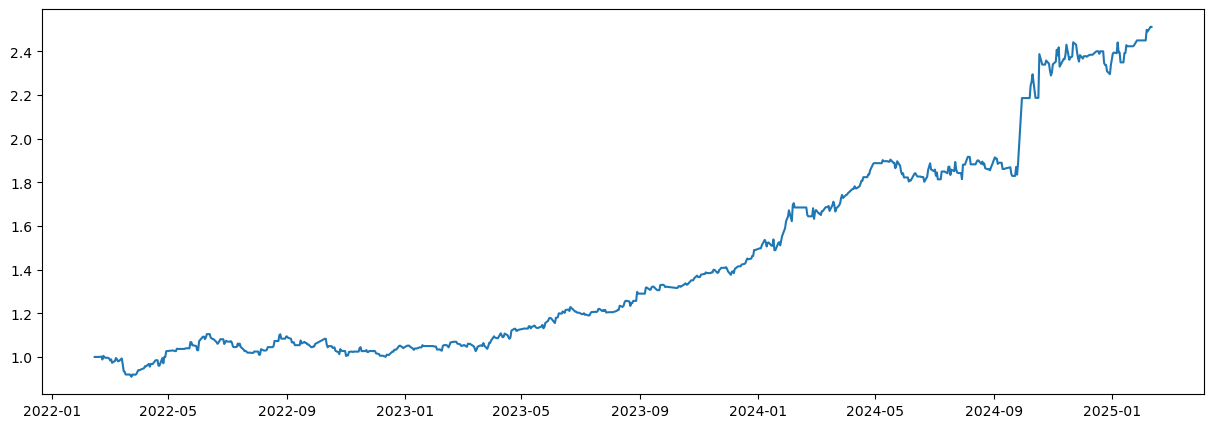

In [153]:
## 未引入止损条件
strategy1 = ETFIntradayStrategy(
    data = F588080,
    factor_name = 'close',
    LimitOpenTime = '10:00', # 限制10:30以后再开仓
    BuyBound = F588080['upper_bound'],
    SellBound = F588080['lower_bound']
)
performance = strategy1.get_performance()

平均持仓时间: 123.628966 分钟
胜率：0.586074
年化收益率：0.607347
年化夏普比率：3.685418


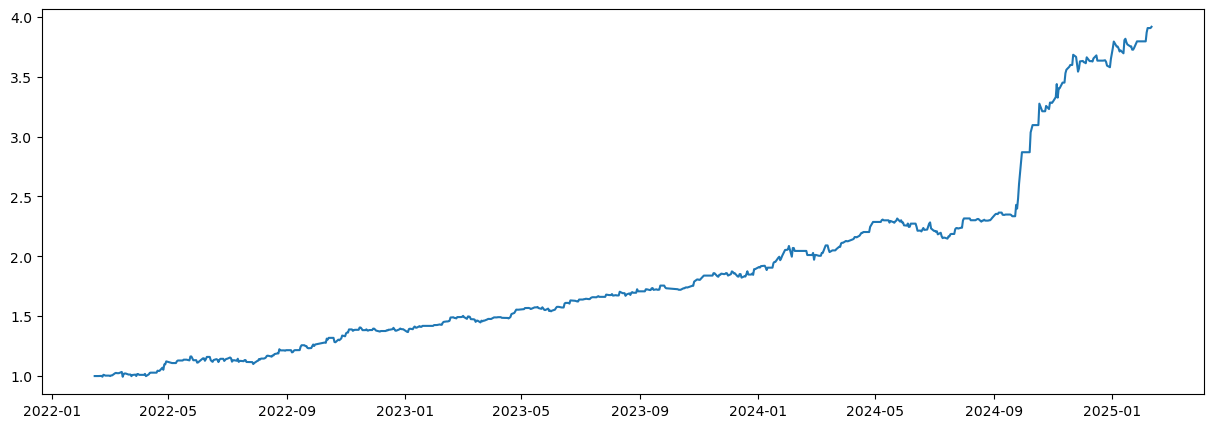

In [152]:
## 未引入止损条件
strategy1 = ETFIntradayStrategy(
    data = F159915,
    factor_name = 'close',
    LimitOpenTime = '10:00', # 限制10:30以后再开仓
    BuyBound = F159915['upper_bound'],
    SellBound = F159915['lower_bound']
)
performance = strategy1.get_performance()